In [1]:
!pip install spacy

In [2]:
# download English corpus for spacy
!python -m spacy download en

symbolic link created for C:\Users\Behnam\Anaconda3\lib\site-packages\spacy\data\en <<===>> C:\Users\Behnam\Anaconda3\lib\site-packages\en_core_web_sm
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[+] Linking successful
C:\Users\Behnam\Anaconda3\lib\site-packages\en_core_web_sm -->
C:\Users\Behnam\Anaconda3\lib\site-packages\spacy\data\en
You can now load the model via spacy.load('en')


You should consider upgrading via the 'C:\Users\Behnam\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import spacy 

spacy.__version__

'2.3.2'

In [2]:
import torch
import torchtext
from torchtext import datasets

import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('dark_background')

### Twitter Sentiment Analysis Dataset
Source: http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/

In [3]:
tweets = pd.read_csv('datasets/tweets/tweets.csv', error_bad_lines = False)

tweets = tweets.head(50000)
tweets.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,neg,Sentiment140,is so sad for my APL frie...
1,2,neg,Sentiment140,I missed the New Moon trail...
2,3,pos,Sentiment140,omg its already 7:30 :O
3,4,neg,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I've been at...
4,5,neg,Sentiment140,i think mi bf is cheating on me!!! ...


The dataframe consists of 4 columns and we want to use only ‘Sentiment’ and ‘SentimentText’.

In [4]:
tweets  = tweets.drop(columns = ['ItemID', 'SentimentSource'], axis = 1)

tweets.head()

,Sentiment,SentimentText
0,neg,is so sad for my APL frie...
1,neg,I missed the New Moon trail...
2,pos,omg its already 7:30 :O
3,neg,.. Omgaga. Im sooo im gunna CRy. I've been at...
4,neg,i think mi bf is cheating on me!!! ...


In [5]:
tweets.shape

(50000, 2)

In [6]:
tweets['Sentiment'].unique()

array(['neg', 'pos'], dtype=object)

In [7]:
tweets.Sentiment.value_counts()

pos    26921
neg    23079
Name: Sentiment, dtype: int64

[Text(0.5, 0, 'Labels')]

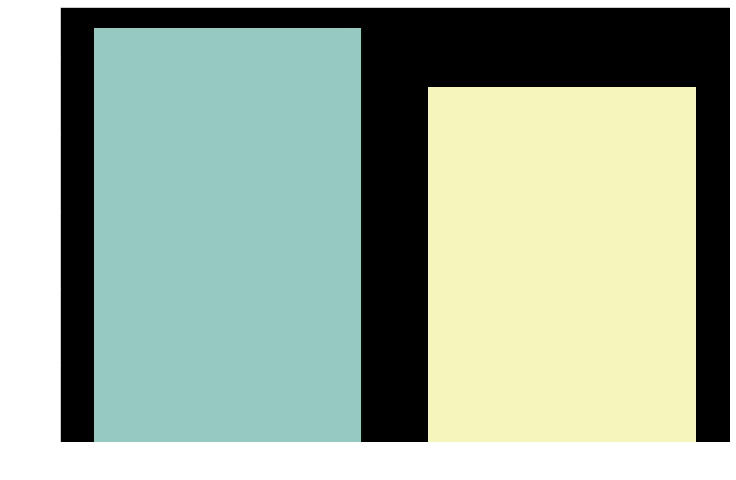

In [8]:
fig = plt.figure(figsize=(12, 8))

ax = sns.barplot(x=tweets.Sentiment.unique(), y=tweets.Sentiment.value_counts())

ax.set(xlabel='Labels')

### It's a binay text classification
- Not an inbalanced data

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(tweets, test_size=0.2, random_state=42)

In [10]:
train.reset_index(drop=True), test.reset_index(drop=True)

(      Sentiment                                      SentimentText
 0           pos  @amyrenea omg so am I lol I fell asleep when i...
 1           neg               @Adrienne_Bailon I want a shout out 
 2           neg  @Anonymousboy03 Plans for school stuff &amp; a...
 3           neg  ... has hit a writer's block .. am loosing my ...
 4           neg  ... trying to find people I know! I`m bored, i...
 ...         ...                                                ...
 39995       pos   #robotpickuplines are so funny. check them out. 
 39996       pos  @annyo84 awh thankss.  yeah, i understand what...
 39997       pos  @AmbiguityX ohh you're in twin cities?  i luv ...
 39998       neg   Dinara lost again in Roland Garros. Why the S...
 39999       pos  *yawn* fucking time zones shit. I'm really sic...
 
 [40000 rows x 2 columns],
      Sentiment                                      SentimentText
 0          pos  @aimeesays aww i hope it does fly by because J...
 1          neg  #don

In [11]:
train.head()

,Sentiment,SentimentText
39087,pos,@amyrenea omg so am I lol I fell asleep when i...
30893,neg,@Adrienne_Bailon I want a shout out
45278,neg,@Anonymousboy03 Plans for school stuff &amp; a...
16398,neg,... has hit a writer's block .. am loosing my ...
13653,neg,"... trying to find people I know! I`m bored, i..."


In [12]:
train.shape, test.shape

((40000, 2), (10000, 2))

In [13]:
train.to_csv('datasets/tweets/train_tweets.csv', index=False)
test.to_csv('datasets/tweets/test_tweets.csv', index=False)

In [14]:
!dir datasets\tweets

 Volume in drive D is SSD
 Volume Serial Number is F6B3-93A4

 Directory of D:\Google Drive\Jupyter Notebooks\Pluralsight - NLP with PyTorch\datasets\tweets

07/31/2020  10:53 PM    <DIR>          .
07/31/2020  10:53 PM    <DIR>          ..
08/08/2020  07:33 PM           828,626 test_tweets.csv
08/08/2020  07:33 PM         3,344,576 train_tweets.csv
06/14/2019  03:48 AM         5,111,924 tweets.csv
               3 File(s)      9,285,126 bytes
               2 Dir(s)  923,120,570,368 bytes free


#### defining a funtion to clean the tweets by removing non alphanumeric character and links 

In [15]:
def tweet_clean(text):
    
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) 
    text = re.sub(r'https?:/\/\S+', ' ', text) 
    
    return text.strip()

####  The tweet column (‘SentimentText’) needs processing and tokenization, so that it can be converted into indices.

In [16]:
# nlp is a spacy object
# we only want the tokenizer so we disable 'parser', 'tagger' and 'ner'
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])

def tokenizer(s): 
    # 1st clean s, then parse it with nlp and last, convert it to lower-case
    return [w.text.lower() for w in nlp(tweet_clean(s))]

In [17]:
# operates on text and tolenize it using the tokenizer function we defined above
TEXT = torchtext.data.Field(tokenize = tokenizer)

# operates on labels and convert them to numeric values
LABEL = torchtext.data.LabelField(dtype = torch.float)

In [18]:
datafields = [('Sentiment', LABEL), ('SentimentText', TEXT)]

#### We create torchtext dataset,TabularDataset which is specially designed to read csv and tsv files and process them. It is a wrapper around pytorch Dataset with additional features. 

In [19]:
trn, tst = torchtext.data.TabularDataset.splits(path = 'datasets/tweets/', 
                                                train = 'train_tweets.csv',
                                                test = 'test_tweets.csv',    
                                                format = 'csv',
                                                skip_header = True,
                                                fields = datafields)

In [20]:
print(f'Number of training examples: {len(trn)}')
print(f'Number of testing examples: {len(tst)}')

Number of training examples: 40000
Number of testing examples: 10000


The `vars()` function returns the `__dict__` attribute of the given object.

In [21]:
# a dict shape object which key is the label and value is a list of tokenized words in lowercase
vars(trn.examples[0])

{'Sentiment': 'pos',
 'SentimentText': ['amyrenea',
  'omg',
  'so',
  'am',
  'i',
  'lol',
  'i',
  'fell',
  'asleep',
  'when',
  'it',
  'was',
  'on',
  'last',
  'night',
  'so',
  'now',
  'i',
  'get',
  'to',
  'finish',
  'it']}

In [22]:
# 1st word in the value list
vars(tst.examples[0])['SentimentText'][0]

'aimeesays'

In [23]:
vars(tst.examples[0])

{'Sentiment': 'pos',
 'SentimentText': ['aimeesays',
  'aww',
  'i',
  'hope',
  'it',
  'does',
  'fly',
  'by',
  'because',
  'jt',
  'episodes',
  'are',
  'usually',
  'really',
  'good',
  'and',
  'it',
  's',
  'early',
  'but',
  'so',
  'far',
  'this',
  'ep',
  'hassn',
  't',
  'disappointed']}

#### Load pretrained word vectors and build vocabulary
Now, instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors. We get these vectors simply by specifying which vectors we want and passing it as an argument to build_vocab. TorchText handles downloading the vectors and associating them with the correct words in our vocabulary.

In [24]:
# build_vocab creates a vocab of the input data in this case, training data
TEXT.build_vocab(trn, max_size=25000, # only top 25,000 word in vocab = size of feature vector 
                 vectors="glove.6B.100d", # index position of words in vocab comes from GloVe
                 unk_init=torch.Tensor.normal_)
                # unknown words in the sentence initialize using normal distribution and not 0

LABEL.build_vocab(trn)

In [25]:
# most common 50 words in vocab with their indices
print(TEXT.vocab.freqs.most_common(50))

[('i', 25644), ('the', 12219), ('to', 12111), ('you', 10723), ('a', 9197), ('it', 8440), ('and', 6889), ('my', 6208), ('quot', 5582), ('s', 5565), ('that', 5306), ('is', 5203), ('for', 4971), ('in', 4852), ('t', 4844), ('m', 4683), ('me', 4588), ('of', 4331), ('on', 3918), ('have', 3752), ('so', 3612), ('but', 3506), ('be', 2932), ('not', 2887), ('was', 2775), ('just', 2724), ('can', 2523), ('do', 2418), ('are', 2351), ('your', 2320), ('with', 2269), ('good', 2203), ('like', 2173), ('at', 2131), ('no', 2119), ('this', 2094), ('all', 2069), ('up', 2066), ('now', 2063), ('get', 2044), ('we', 1988), ('u', 1890), ('love', 1885), ('lol', 1864), ('too', 1826), ('what', 1760), ('out', 1742), ('know', 1664), ('nt', 1608), ('amp', 1539)]


In [26]:
len(TEXT.vocab.itos)

25002

In [27]:
TEXT.vocab['i']

2

### The additional 2 words in `TEXT.vocab` are:
- `pad` : to fill empty spaces for each example
- `unk`: to show words which are not present in train vocab but are in test vocab

In [28]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'i', 'the', 'to', 'you', 'a', 'it', 'and', 'my']


In [29]:
print(LABEL.vocab.stoi)

defaultdict(None, {'pos': 0, 'neg': 1})


#### Loading the data in batches
For data with variable length sentences torchtext provides `BucketIterator()` dataloader which is wrapper around pytorch Dataloader. 
- `BucketIterator()` clump to gether sentences of the same length

In [30]:
len(tweets.SentimentText)

50000

In [31]:
train_iterator, test_iterator = torchtext.data.BucketIterator.splits(
                                (trn, tst),
                                batch_size = 64,
                                #sort based on the length of the SentimentText
                                sort_key=lambda x: len(x.SentimentText), 
                                sort_within_batch=False)

#### We'll be using a different RNN architecture called a Long Short-Term Memory (LSTM).

<b>torch.nn.embedding</b> -A simple lookup table that stores embeddings of a fixed dictionary and size.This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings.


<b>LSTM</b> - Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence.

<b>bidirectional</b> - an RNN processing the words in the sentence from the first to the last (a forward RNN), we have a second RNN processing the words in the sentence from the last to the first (a backward RNN). At time step $t$, the forward RNN is processing word $x_t$, and the backward RNN is processing word $x_{T-t+1}$.


<b>Dropout</b> - it works by randomly dropping out (setting to 0) neurons in a layer during a forward pass. The probability that each neuron is dropped out is set by a hyperparameter and each neuron with dropout applied is considered indepenently.This helps in regularization.


### **Input**
torch.nn.RNN has two inputs : `input` and `h_0` ie. the input sequence and the hidden-layer at t=0. If we don't initialize the hidden layer, it will be auto-initiliased by PyTorch to be all zeros.
- input is the sequence which is fed into the network. It should be of size `(seq_len, batch, input_size)`. If `batch_first=True`, the input size is `(batch, seq_len, input_size)`.
- h_0 is the initial hidden state of the network. It is of the size `(num_layers * num_directions, batch, input_size)` where num_layers is the number of stacked RNNs. num_directions = 2 for bidirectional RNNs and 1 otherwise.


### **Output**
torch.nn.RNN has two outputs - `out` and `hidden`.
`out` is the output of the RNN from all timesteps from the last RNN layer. It is of the size `(seq_len, batch, num_directions * hidden_size)`. If `batch_first=True`, the output size is (`batch, seq_len, num_directions * hidden_size)`.
`h_n` is the hidden value from the last time-step of all RNN layers. It is of the size `(num_layers * num_directions, batch, hidden_size)`. `h_n` is unaffected by `batch_first=True`.


<img src="Images/RNN architecture.png">

###     `output` is the output of the RNN from all timesteps from the last RNN layer.
 ###    `h_n` is the hidden-state value from the last time-step of all RNN layers.

### Attention!
- For multy-layer RNN, the input to the fc layer is concatanation of 2 hidden states

`torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)`

In [111]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, 
                 output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()
        
        # input is in form of one-hot encoed converted to embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers, 
                           bidirectional = bidirectional, dropout=dropout)
        
        #multiply by 2 is because of bidirectionality, 2 hidden state in forward and reverse direction
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, text):
        #print("text", text.shape) = (seq_length, 20) 2o is hidden dim
        
        # 1st convert input text into corresponding embedding and then apply dropout
        embedded = self.dropout(self.embedding(text))
        #print("embedded", embedded.shape) = (seq_length, 64, 20)
        
        # 2 hidden state from forward and backward RNN
        output, hidden = self.rnn(embedded)
        # print("output", output.shape = (seq_length, 64, 40)
        # print("hidden", hidden.shape ) = (4, 64, 20)
        
        # concatenate 2 hidden states into the final hidden state
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        # print("hidden", hidden.shape) is (64, 40)
        
        # print('last', hidden.squeeze(0).shape) is (64, 40)
        # print(self.fc(hidden.squeeze(0)).shape) is (64, 1)                                      
        return self.fc(hidden.squeeze(0))

To ensure the pre-trained vectors can be loaded into the model, the EMBEDDING_DIM must be equal to that of the pre-trained GloVe vectors loaded earlier.

We get our pad token index from the vocabulary, getting the actual string representing the pad token from the field's pad_token attribute, which is pad by default.

In [112]:
input_dim = len(TEXT.vocab) # 25,002

embedding_dim = 100 # corresponds to GloVe embedding (vectors = "glove.6B.100d")

hidden_dim = 20 # simillar t0 20 neurons in RNN layer
output_dim = 1

n_layers = 2 # 2 layers
bidirectional = True

dropout = 0.5

In [113]:
model = RNN(input_dim, 
            embedding_dim, 
            hidden_dim, 
            output_dim, 
            n_layers, 
            bidirectional, 
            dropout)

In [114]:
model

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): GRU(100, 20, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

We retrieve the embeddings from the field's vocab, and check they're the correct size, [vocab size, embedding dim]
- 25,002 most frequent words in our vocab
- each embedding has the dimensionality of 100 

In [115]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 100])


### We then replace the initial weights of the embedding layer with the pre-trained embeddings.

In [116]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.3744, -0.9346, -0.2560,  ..., -1.0419, -1.2345, -0.5804],
        [ 0.6945,  1.8962, -0.1613,  ..., -2.2072, -2.3925, -1.2877],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [-1.9859,  0.6130, -0.2060,  ...,  0.2449,  0.2522, -0.9568],
        [-1.1472, -0.5669,  0.8012,  ..., -0.4997,  0.1264, -0.4542],
        [ 0.8382, -0.2901, -0.6670,  ..., -0.6708,  1.2218, -0.7844]])

### Setting `unk` and `pad` tokens to zero, means they have no value in understanding the sentiment
As our < unk > and < pad > token aren't in the pre-trained vocabulary they have been initialized using unk_init (an $\mathcal{N}(0,1)$ distribution) when building our vocab. It is preferable to initialize them both to all zeros to explicitly tell our model that, initially, they are irrelevant for determining sentiment.

In [117]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

print('unk_idx: ', unk_idx, '\npad_idx: ', pad_idx )

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)

unk_idx:  0 
pad_idx:  1
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [-1.9859,  0.6130, -0.2060,  ...,  0.2449,  0.2522, -0.9568],
        [-1.1472, -0.5669,  0.8012,  ..., -0.4997,  0.1264, -0.4542],
        [ 0.8382, -0.2901, -0.6670,  ..., -0.6708,  1.2218, -0.7844]])


#### As you can see above,  the first 2 vectors are zero


### Let's see the embedding of a given word

In [118]:
TEXT.vocab.stoi['ufc']

8300

In [119]:
model.embedding.weight.data[TEXT.vocab.stoi['ufc']]

tensor([ 0.5941, -0.2980,  0.4845, -1.0484, -0.1234, -0.7606, -0.3824,  0.0547,
        -0.5145,  0.4720,  1.1300, -0.6752,  0.5322, -1.4753,  0.7268, -1.0578,
         0.7085, -0.0226,  0.6492, -0.5271,  0.5378, -1.3725,  0.6805,  0.3684,
         0.3946,  0.3264,  0.7379,  0.3787,  1.4240,  0.8743, -0.9630, -0.2236,
        -0.2297,  0.4366,  0.1340,  0.7371, -0.6388,  0.0802, -0.4933,  0.5903,
        -0.1161,  0.1407,  0.2577, -0.6073,  0.1068, -0.4910, -0.5081,  0.0193,
        -0.8991,  0.5141, -0.6505,  0.0244, -0.4841,  0.4380,  1.1311, -0.9572,
         0.2540,  0.0479, -1.1566,  0.1825,  0.1217, -0.2933, -0.9783,  0.0429,
        -0.1324, -1.1153, -0.1110, -0.4143, -0.7511,  0.3366,  0.0281, -0.4760,
        -1.0994,  1.0847,  0.1064,  0.0838, -0.3123,  0.3206, -0.6370,  0.4812,
         0.0880, -0.9473,  0.8987, -0.4394,  0.5618, -0.5753, -0.1427,  0.1543,
         0.3749, -0.0160, -0.0100, -0.1311, -0.1834,  1.4182, -0.0115, -0.5173,
         0.2775,  1.1060,  0.6482, -0.11

#### Train the Model

We use Adam optimizer and loss function is BCEWithLogitLoss 

In [120]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss() # this loss function is for binary classification

#### We define a function for training our model
as we are now using dropout, we must remember to use model.train() to ensure the dropout is "turned on" while training.

In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [122]:
def train(model, iterator, optimizer, criterion):
    
    model.to(device)
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        batch.SentimentText = batch.SentimentText.to(device)
        batch.Sentiment = batch.Sentiment.to(device)
        
        # output of the model is: (batch_size, 1) and we get rid of 1 with sueeze(dim=1)
        predictions = model(batch.SentimentText).squeeze(1)
        
        loss = criterion(predictions, batch.Sentiment)
        
        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.Sentiment).float() 
        
        acc = correct.sum() / len(correct)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [124]:
num_epochs = 10

for epoch in range(num_epochs):
     
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 0.545 | Train Acc: 73.10% |
| Epoch: 02 | Train Loss: 0.498 | Train Acc: 76.47% |
| Epoch: 03 | Train Loss: 0.469 | Train Acc: 78.03% |
| Epoch: 04 | Train Loss: 0.445 | Train Acc: 79.47% |
| Epoch: 05 | Train Loss: 0.428 | Train Acc: 80.66% |
| Epoch: 06 | Train Loss: 0.411 | Train Acc: 81.75% |
| Epoch: 07 | Train Loss: 0.392 | Train Acc: 82.61% |
| Epoch: 08 | Train Loss: 0.380 | Train Acc: 83.32% |
| Epoch: 09 | Train Loss: 0.362 | Train Acc: 84.09% |
| Epoch: 10 | Train Loss: 0.351 | Train Acc: 84.90% |


### Evaluating the model

epoch_loss = 0
epoch_acc = 0

model.eval()

with torch.no_grad():

    for batch in test_iterator:
        
        batch.SentimentText = batch.SentimentText.to(device)
        batch.Sentiment = batch.Sentiment.to(device)

        predictions = model(batch.SentimentText).squeeze(1)

        loss = criterion(predictions, batch.Sentiment)

        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.Sentiment).float() 
        
        acc = correct.sum()/len(correct)

        epoch_loss += loss.item()
        epoch_acc += acc.item()


test_loss = epoch_loss / len(test_iterator)
test_acc = epoch_acc / len(test_iterator)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [45]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            batch.SentimentText = batch.SentimentText.to(device)
            batch.Sentiment = batch.Sentiment.to(device)
#             text = text.to(device)
#             batch.label = batch.label.to(device)
        
            predictions = model(batch.SentimentText).squeeze(1)

            loss = criterion(predictions, batch.Sentiment)

            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            correct = (rounded_preds == batch.Sentiment).float() 
            
            acc = correct.sum() / len(correct)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Let's save the best model


In [87]:
N_EPOCHS = 2
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    print(f"Epoch: {epoch}")
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, test_iterator, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 0
	Train Loss: 0.149 | Train Acc: 94.22%
	 Val. Loss: 0.791 |  Val. Acc: 74.14%
Epoch: 1
	Train Loss: 0.144 | Train Acc: 94.27%
	 Val. Loss: 0.792 |  Val. Acc: 73.99%


### Load the saved model

In [46]:
model = RNN(input_dim, 
            embedding_dim, 
            hidden_dim, 
            output_dim, 
            n_layers, 
            bidirectional, 
            dropout)
model.load_state_dict(torch.load('model_gru_GloVe.pt'))
model.to(device)

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): GRU(100, 20, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [47]:
print(model)

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): GRU(100, 20, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## User Input
We can now use our model to predict the sentiment of any sentence we give it.As it has been trained on tweets, the sentences provided should in a positive or a negative context.

We are expecting tweets with a negative sentiment to return a value close to 1 and positive tweets to return a value close to 0


In [48]:
sentence = 'I hate that show' 

In [49]:
# tokenize the sentence using spacy tokenizer created earlier
tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
tokenized

['I', 'hate', 'that', 'show']

In [50]:
# index of word in the GloVe vocab 
TEXT.vocab.stoi['hate']

185

In [51]:
indexed = [TEXT.vocab.stoi[t] for t in tokenized]
indexed

[0, 185, 12, 165]

In [52]:
# converting indices to tensor
tensor = torch.LongTensor(indexed)
tensor

tensor([  0, 185,  12, 165])

In [53]:
# adding another dimension because our model expects it
tensor = tensor.unsqueeze(1)

In [54]:
tensor = tensor.to(device)
prediction = torch.sigmoid(model(tensor))

In [55]:
print(LABEL.vocab.stoi)

defaultdict(None, {'pos': 0, 'neg': 1})


In [56]:
prediction.item()

0.7903881669044495

In [57]:
print("this prediction is near 1 so it belongs to negative")

this prediction is near 1 so it belongs to negative


### Let's define a function

In [58]:
sentences =[ "do you hate ufc or you love it?",
"That movie was really nice",
"I hate that show but recently it has been quite good",
"That movie was decent but kind of fizzled out towards the end"]

In [59]:
import numpy as np

def predict_label(sentences):
    for sentence in sentences:
        tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
        indexed = [TEXT.vocab.stoi[t] for t in tokenized]
        tensor = torch.LongTensor(indexed).unsqueeze(1)
        tensor = tensor.to(device)
        prediction = torch.sigmoid(model(tensor))        
        if np.round(prediction.item()) == 1:
            print(sentence,": negative", np.around(prediction.item(), 2))
        else:
            print(sentence,": positive", np.around(prediction.item(), 2))

In [60]:
predict_label(sentences)

do you hate ufc or you love it? : negative 0.93
That movie was really nice : positive 0.08
I hate that show but recently it has been quite good : negative 0.65
That movie was decent but kind of fizzled out towards the end : positive 0.05
